In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, espra, gaussian_vel_reconstruction, normalize_matrix
from utils import moca, smooth, deg_to_m, calc_tang_vel_max_r, calc_tang_vel

import re
def depth_key(col):
    # assumes columns like 'u_10', 'v_219', etc.
    return int(re.split(r'u_|v_', col)[1])


#### IMOS Data

In [2]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

#### Ship Data

In [3]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=['u_' + str(z) for z in z_sadcp]).T
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=['v_' + str(z) for z in z_sadcp]).T
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Time': tim_sadcp, 'Lon': lon_sadcp, 'Lat': lat_sadcp})
df_sadcp = pd.concat([df_sadcp, u_sadcp, v_sadcp], axis=1)

df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
# df_sadcp = df_sadcp[df_sadcp['Lon'] <= 155]
df_sadcp= df_sadcp.reset_index().drop(columns=['index'])

df_sadcp


,Time,Lon,Lat,u_27,u_37,u_47,u_57,u_67,u_77,u_87,...,v_717,v_727,v_737,v_747,v_757,v_767,v_777,v_787,v_797,v_807
0,2023-10-17 10:27:31.000004,154.357059,-37.005208,NaN,0.534412,0.569007,0.549270,0.465635,0.374654,0.323217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-10-17 10:42:30.333327,154.360804,-37.038123,NaN,0.533096,0.555601,0.561888,0.484809,0.402146,0.357385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-10-17 10:57:30.666685,154.364625,-37.071899,NaN,0.431565,0.456292,0.483472,0.458337,0.434674,0.398060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-10-17 11:12:30.333340,154.368274,-37.101418,NaN,0.368063,0.378524,0.410269,0.398222,0.362505,0.358032,...,0.043875,0.044484,0.043708,0.042462,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-10-17 11:27:30.666659,154.372221,-37.104340,NaN,0.357789,0.368125,0.399916,0.385093,0.353109,0.356878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,2023-10-21 21:27:30.333314,154.179344,-37.150309,NaN,0.246921,0.241454,0.244281,0.212926,0.202732,0.233854,...,0.056159,0.075346,0.080013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,2023-10-21 21:42:30.666672,154.179347,-37.119931,NaN,0.222701,0.196322,0.206364,0.223129,0.236286,0.265476,...,0.056037,0.093465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430,2023-10-21 21:57:30.333327,154.179332,-37.088953,NaN,0.214721,0.206698,0.228885,0.243320,0.250907,0.249915,...,0.084378,0.079553,0.085535,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,2023-10-21 22:12:30.333314,154.179352,-37.058304,NaN,0.219740,0.226015,0.243559,0.245731,0.227310,0.231003,...,0.093274,0.105179,0.077085,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
lon0, lon1 = 152, 157
lat0, lat1 = -39.5, -36.5


1.219021992782062


(np.float64(152.6500030517578),
 np.float64(155.95000305175782),
 np.float64(-39.550001525878905),
 np.float64(-36.25000152587891))

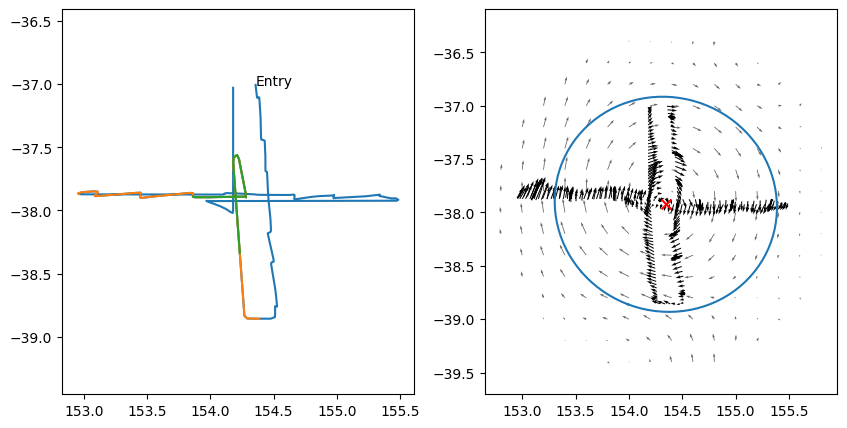

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

t1 = pd.Timestamp('2023-10-19 5:00:00')
days1 = .3
df_esp = df_sadcp[(df_sadcp.Time >= t1 - pd.Timedelta(days=days1)) & (df_sadcp.Time <= t1 + pd.Timedelta(days=days1))]

tRc = pd.Timestamp('2023-10-19 8:30:00')
daysRc = .65
df_Rc = df_sadcp[(df_sadcp.Time >= tRc - pd.Timedelta(days=daysRc)) & (df_sadcp.Time <= tRc + pd.Timedelta(days=daysRc))]

axs[0].plot(df_sadcp.Lon, df_sadcp.Lat)
axs[0].plot(df_Rc.Lon, df_Rc.Lat)
axs[0].plot(df_esp.Lon, df_esp.Lat)
axs[0].text(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0], 'Entry')
axs[0].set_xlim(lon0, lon1)
axs[0].set_ylim(lat0, lat1)
axs[0].axis('equal')

df_clean = df_esp[['Lon', 'Lat', 'u_37', 'v_37']].copy().dropna()
xc, yc, w, Q, _, _, _ = espra(df_clean.Lon, df_clean.Lat, df_clean.u_37, df_clean.v_37)
w /= deg_to_m(yc)

df_cleanRc = df_Rc[['Lon', 'Lat', 'u_37', 'v_37']].copy().dropna()
Rc = calc_tang_vel_max_r(xc, yc, df_cleanRc.Lon, df_cleanRc.Lat, df_cleanRc.u_37, df_cleanRc.v_37)
print(Rc)

# psi0 = find_optimal_psi0(df_cleanRc.Lon, df_cleanRc.Lat, df_cleanRc.u_37, df_cleanRc.v_37,
#                       xc, yc, Q[0,0], Q[1,0], Q[1,1])

closest = min(tim_ssh, key=lambda tt: abs(tt - t1))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
mask = np.hypot(lon_ssh - xc, lat_ssh - yc) < 1.6
axs[1].quiver(lon_ssh[mask], lat_ssh[mask], ut[mask], vt[mask], scale=20, zorder=1, width=.0023, color='k', alpha=.6)#'#1f77b4')
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale = Rc)
axs[1].plot(x_ell, y_ell)
axs[1].quiver(df_sadcp.Lon, df_sadcp.Lat, df_sadcp.u_37, df_sadcp.v_37)
axs[1].scatter(xc, yc, marker='x', color='r', s=50)

axs[1].set_xlim(lon0, lon1)
axs[1].set_ylim(lat0, lat1)
axs[1].axis('equal')


In [6]:
u_cols = sorted([c for c in df_esp.columns if c.startswith('u_')], key=depth_key)
v_cols = sorted([c for c in df_esp.columns if c.startswith('v_')], key=depth_key)

u_colsRc = sorted([c for c in df_Rc.columns if c.startswith('u_')], key=depth_key)
v_colsRc = sorted([c for c in df_Rc.columns if c.startswith('v_')], key=depth_key)

results = []
for u_col, v_col, u_colRc, v_colRc in zip(u_cols, v_cols, u_colsRc, v_colsRc):
    depth = depth_key(u_col)

    df_clean = df_esp[['Lon','Lat',u_col,v_col]].copy().dropna()
    if df_clean.empty:
        continue

    df_cleanRc = df_Rc[['Lon','Lat',u_colRc,v_colRc]].copy().dropna()
    if df_cleanRc.empty:
        continue

    xc, yc, w, Q, _, psi0, _ = espra(
        df_clean['Lon'].values,
        df_clean['Lat'].values,
        df_clean[u_col].values,
        df_clean[v_col].values
    )

    w /= deg_to_m(yc)  # match first block exactly

    Rc = calc_tang_vel_max_r(
        xc, yc,
        df_cleanRc['Lon'].values,
        df_cleanRc['Lat'].values,
        df_cleanRc[u_colRc].values,
        df_cleanRc[v_colRc].values,
        cyc='CE'
    )

    s = -Rc**2 / psi0
    q = s * Q

    results.append({
        'xc': xc,
        'yc': yc,
        'w': w,
        'Q': Q,
        'Rc': Rc,
        'psi0': psi0,
        'q': q,
        'Depth': depth
    })

df_results = pd.DataFrame(results)
df_results = df_results[df_results['Depth'] <= 680]

df_results['sRc'] = smooth(df_results.Rc.values, df_results.Depth.values,
                           num=len(df_results), window=round(.1*len(df_results)))
df_results['spsi0'] = smooth(df_results.psi0.values, df_results.Depth.values,
                           num=len(df_results), window=round(.1*len(df_results)))

df_results


,xc,yc,w,Q,Rc,psi0,q,Depth,sRc,spsi0
0,154.345586,-37.923586,-0.000025,"[[-0.8469194101978027, -0.02526943043219398], ...",1.219022,3.259423,"[[0.386121911474323, 0.01152067205316188], [0....",37,1.226537,3.477770
1,154.351620,-37.917914,-0.000024,"[[-0.8220455325771786, -0.012342772674778676],...",1.224882,3.577490,"[[0.34475135688679404, 0.0051763405538314145],...",47,1.230752,3.493964
2,154.362663,-37.909006,-0.000024,"[[-0.7856933022073451, 0.0056177403002952864],...",1.235708,3.596398,"[[0.33359305203604106, -0.0023852044138042176]...",57,1.236029,3.433535
3,154.370480,-37.901684,-0.000022,"[[-0.7378411718025264, 0.014601841387943008], ...",1.243397,3.542545,"[[0.32200838376809227, -0.00637253046462955], ...",67,1.245605,3.297800
4,154.384322,-37.891320,-0.000021,"[[-0.6643711220315979, 0.024374940776905715], ...",1.257133,3.191820,"[[0.32895399846068824, -0.01206890842318137], ...",77,1.252842,3.153152
...,...,...,...,...,...,...,...,...,...,...
60,154.392069,-37.897263,-0.000016,"[[-0.4334472721290313, -0.018776200431432], [-...",0.385194,4.934839,"[[0.013032302786064643, 0.0005645372457700378]...",637,0.384483,4.717674
61,154.399649,-37.894515,-0.000016,"[[-0.4247142692417963, -0.0016952917171243458]...",0.390991,4.847211,"[[0.013394892219277005, 5.346712242951626e-05]...",647,0.389633,4.862563
62,154.406119,-37.889401,-0.000016,"[[-0.4120245348926238, 0.009864800589830948], ...",0.398468,5.119248,"[[0.012779234929910677, -0.0003059638288458339...",657,0.393854,4.947881
63,154.404989,-37.875311,-0.000016,"[[-0.43022589242600207, 0.038610288480247515],...",0.410580,5.044184,"[[0.014378075038789555, -0.001290349174262667]...",667,0.397671,5.088214


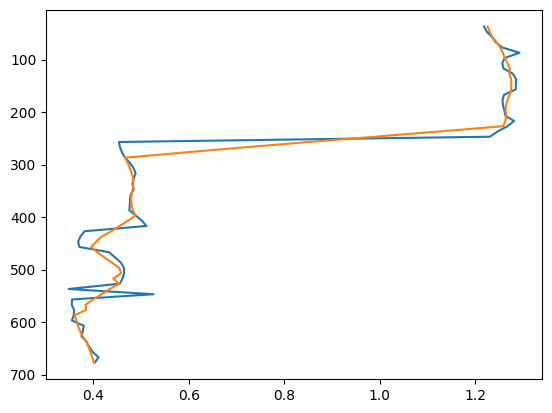

In [7]:
fig, ax = plt.subplots()
ax.plot(df_results.Rc, df_results.Depth)
ax.plot(df_results.sRc, df_results.Depth)
ax.invert_yaxis()


#### Find rough guess of r_max at each depth

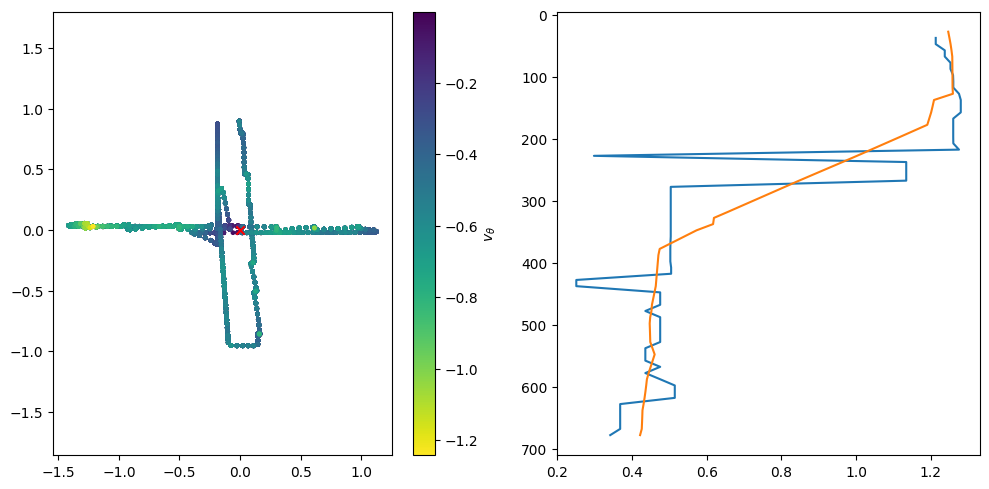

In [8]:
xc_ave, yc_ave = df_results.xc.mean(), df_results.yc.mean()

u_cols = sorted([c for c in df_sadcp.columns if c.startswith('u_')], key=depth_key)
v_cols = sorted([c for c in df_sadcp.columns if c.startswith('v_')], key=depth_key)

vts, r_maxs, xs, ys, zs = [], [], [], [], []
for u_col, v_col in zip(u_cols, v_cols):
    lons = df_sadcp['Lon'].to_numpy()
    lats = df_sadcp['Lat'].to_numpy()
    us   = df_sadcp[u_col].to_numpy()
    vs   = df_sadcp[v_col].to_numpy()
    z = int(u_col[2:])
    if z <= 680:
        zs.append(z)
        m = np.isfinite(lons) & np.isfinite(lats) & np.isfinite(us) & np.isfinite(vs)
        vt = calc_tang_vel(xc_ave, yc_ave, lons[m], lats[m], us[m], vs[m])
        r_maxs.append(calc_tang_vel_max_r(xc_ave, yc_ave, lons[m], lats[m], us[m], vs[m], 'CE'))
        vts.append(vt); xs.append(lons[m]); ys.append(lats[m])
df_Rc_levels = pd.DataFrame({'r_max': r_maxs, 'Depth': zs})

df_Rc_levels['sr_max'] = smooth(df_Rc_levels.r_max.values, df_Rc_levels.Depth.values,
                           num=len(df_Rc_levels), window=round(.3*len(df_Rc_levels)))

vts = np.concatenate(vts)
xs  = np.concatenate(xs)
ys  = np.concatenate(ys)

m = vts <= 0  # Cyclonic
vts = vts[m]; xs = xs[m]; ys = ys[m]

idx = np.argsort(np.abs(vts))
vts = vts[idx]; xs = xs[idx]; ys = ys[idx]

fig, axs = plt.subplots(1, 2, figsize=(10,5))

sc = axs[0].scatter(xs-xc_ave, ys-yc_ave, c=vts, s=6, cmap='viridis_r')
fig.colorbar(sc, ax=axs[0], label=r'$v_\theta$')
axs[0].scatter([0], [0], marker='x', c='r')
axs[0].axis('equal')

axs[1].plot(df_Rc_levels.r_max, df_Rc_levels.Depth)
axs[1].plot(df_Rc_levels.sr_max, df_Rc_levels.Depth)
axs[1].invert_yaxis()

plt.tight_layout()


In [25]:
df_results['R_levels'] = df_Rc_levels.dropna().sr_max.values
df_results


,xc,yc,w,Q,Rc,psi0,q,Depth,sRc,spsi0,R_levels
0,154.345586,-37.923586,-0.000025,"[[-0.8469194101978027, -0.02526943043219398], ...",1.219022,3.259423,"[[0.386121911474323, 0.01152067205316188], [0....",37,1.226537,3.477770,1.250398
1,154.351620,-37.917914,-0.000024,"[[-0.8220455325771786, -0.012342772674778676],...",1.224882,3.577490,"[[0.34475135688679404, 0.0051763405538314145],...",47,1.230752,3.493964,1.253437
2,154.362663,-37.909006,-0.000024,"[[-0.7856933022073451, 0.0056177403002952864],...",1.235708,3.596398,"[[0.33359305203604106, -0.0023852044138042176]...",57,1.236029,3.433535,1.255924
3,154.370480,-37.901684,-0.000022,"[[-0.7378411718025264, 0.014601841387943008], ...",1.243397,3.542545,"[[0.32200838376809227, -0.00637253046462955], ...",67,1.245605,3.297800,1.257996
4,154.384322,-37.891320,-0.000021,"[[-0.6643711220315979, 0.024374940776905715], ...",1.257133,3.191820,"[[0.32895399846068824, -0.01206890842318137], ...",77,1.252842,3.153152,1.258192
...,...,...,...,...,...,...,...,...,...,...,...
60,154.392069,-37.897263,-0.000016,"[[-0.4334472721290313, -0.018776200431432], [-...",0.385194,4.934839,"[[0.013032302786064643, 0.0005645372457700378]...",637,0.384483,4.717674,0.428022
61,154.399649,-37.894515,-0.000016,"[[-0.4247142692417963, -0.0016952917171243458]...",0.390991,4.847211,"[[0.013394892219277005, 5.346712242951626e-05]...",647,0.389633,4.862563,0.427474
62,154.406119,-37.889401,-0.000016,"[[-0.4120245348926238, 0.009864800589830948], ...",0.398468,5.119248,"[[0.012779234929910677, -0.0003059638288458339...",657,0.393854,4.947881,0.426843
63,154.404989,-37.875311,-0.000016,"[[-0.43022589242600207, 0.038610288480247515],...",0.410580,5.044184,"[[0.014378075038789555, -0.001290349174262667]...",667,0.397671,5.088214,0.426106


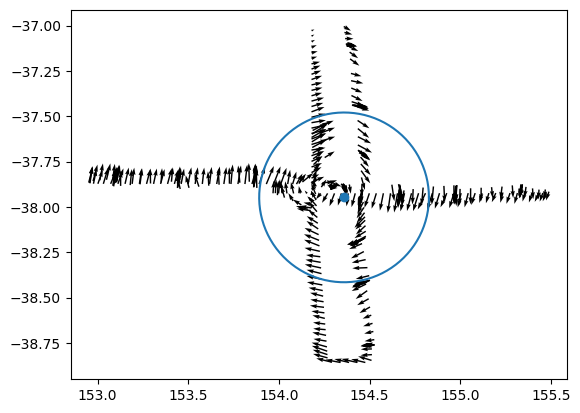

In [47]:
depth = 407

u = df_sadcp[f'u_{depth}']
v = df_sadcp[f'v_{depth}']

plt.quiver(df_sadcp.Lon, df_sadcp.Lat, u, v)
plt.axis('equal')

data = df_results[df_results.Depth==depth].iloc[0]
plt.scatter(data.xc, data.yc)

theta = np.linspace(0, 2*np.pi, 200)
x_circ = data.xc + data.R_levels * np.cos(theta)
y_circ = data.yc + data.R_levels * np.sin(theta)
plt.plot(x_circ, y_circ)


In [37]:
df_sadcp

,Time,Lon,Lat,u_27,u_37,u_47,u_57,u_67,u_77,u_87,...,v_717,v_727,v_737,v_747,v_757,v_767,v_777,v_787,v_797,v_807
0,2023-10-17 10:27:31.000004,154.357059,-37.005208,NaN,0.534412,0.569007,0.549270,0.465635,0.374654,0.323217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-10-17 10:42:30.333327,154.360804,-37.038123,NaN,0.533096,0.555601,0.561888,0.484809,0.402146,0.357385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-10-17 10:57:30.666685,154.364625,-37.071899,NaN,0.431565,0.456292,0.483472,0.458337,0.434674,0.398060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-10-17 11:12:30.333340,154.368274,-37.101418,NaN,0.368063,0.378524,0.410269,0.398222,0.362505,0.358032,...,0.043875,0.044484,0.043708,0.042462,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-10-17 11:27:30.666659,154.372221,-37.104340,NaN,0.357789,0.368125,0.399916,0.385093,0.353109,0.356878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,2023-10-21 21:27:30.333314,154.179344,-37.150309,NaN,0.246921,0.241454,0.244281,0.212926,0.202732,0.233854,...,0.056159,0.075346,0.080013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,2023-10-21 21:42:30.666672,154.179347,-37.119931,NaN,0.222701,0.196322,0.206364,0.223129,0.236286,0.265476,...,0.056037,0.093465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430,2023-10-21 21:57:30.333327,154.179332,-37.088953,NaN,0.214721,0.206698,0.228885,0.243320,0.250907,0.249915,...,0.084378,0.079553,0.085535,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,2023-10-21 22:12:30.333314,154.179352,-37.058304,NaN,0.219740,0.226015,0.243559,0.245731,0.227310,0.231003,...,0.093274,0.105179,0.077085,NaN,NaN,NaN,NaN,NaN,NaN,NaN


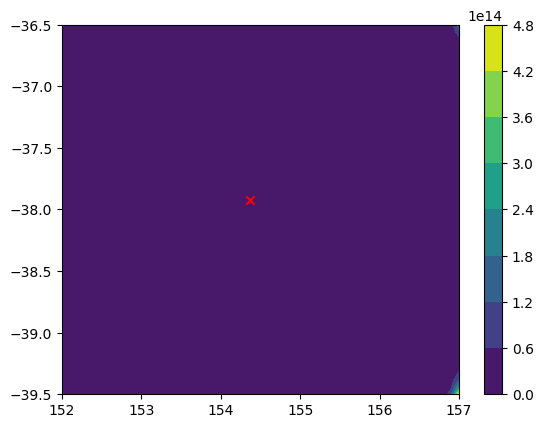

In [34]:
X, Y = np.meshgrid(np.linspace(lon0, lon1, 51), np.linspace(lat0, lat1, 51))

U, V = np.zeros((X.shape[0], X.shape[1], len(df_results))), np.zeros((X.shape[0], X.shape[1], len(df_results)))

for k in range(U.shape[-1]):
    data = df_results.iloc[k]
    uk, vk, *_ = gaussian_vel_reconstruction(data.xc, data.yc,
                                             data.Q[0,0], data.Q[1,0], data.Q[1,1],
                                             data.R_levels, data.spsi0, X, Y)
    U[:,:,k], V[:,:,k] = uk, vk

k = 40
data = df_results.iloc[k]
plt.quiver(X, Y, U[:,:,k], V[:,:,k], scale=30)
plt.contourf(X, Y, np.hypot(U[:,:,k], V[:,:,k]))
plt.colorbar()
plt.scatter(data.xc, data.yc, marker='x', color='r')
